In [1]:
##Loading required libraries
library(tidyverse)
library(repr)
library(Matrix)
library(Seurat)
library(broom)
library(ggridges)
library(ggrepel)
library(patchwork)
library(data.table)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
##Reading in data and creating a seaurat object

data_dir <- '/net/shendure/vol10/www/content/members/CRISPRa_QTL_website/public/data/K562_data/sequencing_data/cellranger_aggr_output/outs/count/filtered_feature_bc_matrix/'
list.files(data_dir)

CRISPRaQTL_Pilot_data <- Read10X(data.dir = data_dir)
CRISPRaQTL_Pilot_Seurat_Object = CreateSeuratObject(counts = CRISPRaQTL_Pilot_data$`Gene Expression`, min.cells = 4, min.features = 200)

CRISPRaQTL_Pilot_Seurat_Object

[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"

10X data contains more than one type and is being returned as a list containing matrices of each type.



An object of class Seurat 
20842 features across 41093 samples within 1 assay 
Active assay: RNA (20842 features, 0 variable features)

In [3]:
##Checking how much mito DNA we have in the Seurat object

CRISPRaQTL_Pilot_Seurat_Object[["percent.mt"]] <- PercentageFeatureSet(CRISPRaQTL_Pilot_Seurat_Object, pattern = "^MT-")

In [4]:
##Filtering for high quality cells 

CRISPRaQTL_Pilot_Seurat_Object_Subset <- subset(CRISPRaQTL_Pilot_Seurat_Object, subset = percent.mt < 10 & nCount_RNA > 4000)

CRISPRaQTL_Pilot_Seurat_Object_Subset

An object of class Seurat 
20842 features across 33994 samples within 1 assay 
Active assay: RNA (20842 features, 0 variable features)

In [6]:
##Reading in Feature Barcode Matrix

matrix_dir = "/net/shendure/vol10/www/content/members/CRISPRa_QTL_website/public/data/K562_data/sequencing_data/cellranger_aggr_output/outs/count/filtered_feature_bc_matrix/"
barcode.path <- paste0(matrix_dir, "barcodes.tsv.gz")
features.path <- paste0(matrix_dir, "features.tsv.gz")
matrix.path <- paste0(matrix_dir, "matrix.mtx.gz")
mat <- readMM(file = matrix.path)
feature.names = read.delim(features.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
barcode.names = read.delim(barcode.path,
                           header = FALSE,
                           stringsAsFactors = FALSE)
colnames(mat) = barcode.names$V1
rownames(mat) = feature.names$V1

In [7]:
##Indexing the matrix for only good cells in the seurat object

x <- rownames(CRISPRaQTL_Pilot_Seurat_Object_Subset@meta.data)

Seurat_Filtered_FBC_Mat <- mat[ ,x]

head(Seurat_Filtered_FBC_Mat)

   [[ suppressing 34 column names ‘AAACCCAAGAAGAACG-1’, ‘AAACCCAAGTAACGAT-1’, ‘AAACCCACACCTCGTT-1’ ... ]]



6 x 33994 sparse Matrix of class "dgTMatrix"
                                                                               
ENSG00000243485 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSG00000237613 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSG00000186092 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSG00000238009 . . . . . . . 1 . . . . . . . . . . . . . . . . . . . . . . . .
ENSG00000239945 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
ENSG00000239906 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                          
ENSG00000243485 . . ......
ENSG00000237613 . . ......
ENSG00000186092 . . ......
ENSG00000238009 . . ......
ENSG00000239945 . . ......
ENSG00000239906 . . ......

 .....suppressing 33960 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

In [8]:
##Creating a dataframe version of the full filtered FBC 

transposed_mat <- t(Seurat_Filtered_FBC_Mat)

FBC_DF <- tidy(transposed_mat)  %>% 
    rename(Cell = row) %>% 
    rename(Gene = column) %>% 
    rename(UMI_Count = value)

head(FBC_DF)

Warning message:
“'tidy.dgTMatrix' is deprecated.
See help("Deprecated")”


,Cell,Gene,UMI_Count
,<chr>,<chr>,<dbl>
1,AAACCCAAGAAGAACG-1,ENSG00000188976,2
2,AAACCCAAGAAGAACG-1,ENSG00000188290,1
3,AAACCCAAGAAGAACG-1,ENSG00000131591,1
4,AAACCCAAGAAGAACG-1,ENSG00000169972,1
5,AAACCCAAGAAGAACG-1,ENSG00000175756,2
6,AAACCCAAGAAGAACG-1,ENSG00000242485,8


In [9]:
##Normalize the data with seurats default paramters before statistical testing

CRISPRaQTL_Pilot_Seurat_Object_Subset <- NormalizeData(CRISPRaQTL_Pilot_Seurat_Object_Subset)

In [10]:
##Creating reference dataframes with gRNA-gene and gene-gRNA mappings

Ft_Ref <- read_csv("/net/shendure/vol10/www/content/members/CRISPRa_QTL_website/public/data/K562_data/cellranger_input_files/feature_reference.csv")  %>% 
    rename(gRNA = id)
    

Rows: 493 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): id, name, read, pattern, sequence, feature_type, target_gene_id, ta...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "finished testing"
             p_val avg_log2FC pct.1 pct.2    p_val_adj
ANXA1 9.896659e-36  0.9947902 0.988 0.898 2.062662e-31


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ANXA1,9.896659e-36,0.9947902,0.988,0.898,2.062662e-31,166,33828


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 25 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 25 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 30 rows containing missing values (geom_violin).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 13 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 13 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”


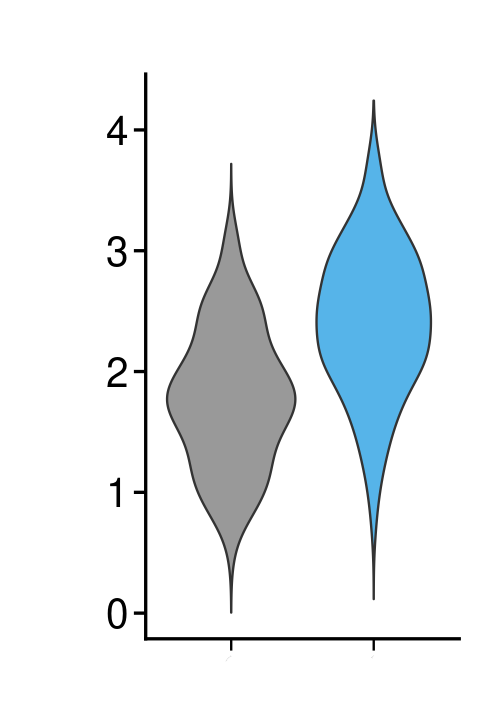

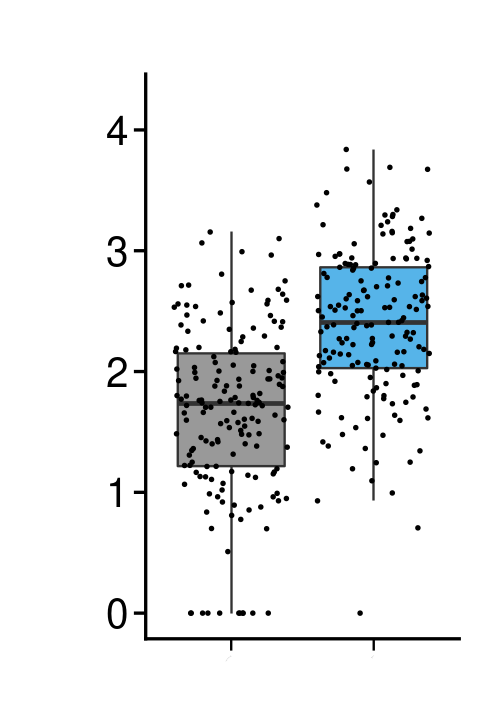

In [34]:
##Making violin for ANXA1 enhancer hit 

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("chr9.871_489_Gasperini_enhancer")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "ANXA1", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

Control_Cells_DS <- sample(Control_Cells, 178)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'ANXA1', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001,4.25), breaks = c(0,1,2,3,4)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter(size = 0.5) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0,4.25), breaks = c(0,1,2,3,4)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

[1] "finished testing"
             p_val avg_log2FC pct.1 pct.2    p_val_adj
ANXA1 1.792928e-31  0.9866594 0.984 0.898 3.736821e-27


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ANXA1,1.792928e-31,0.9866594,0.984,0.898,3.736821e-27,128,33866


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 25 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 25 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 19 rows containing missing values (geom_violin).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 11 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”


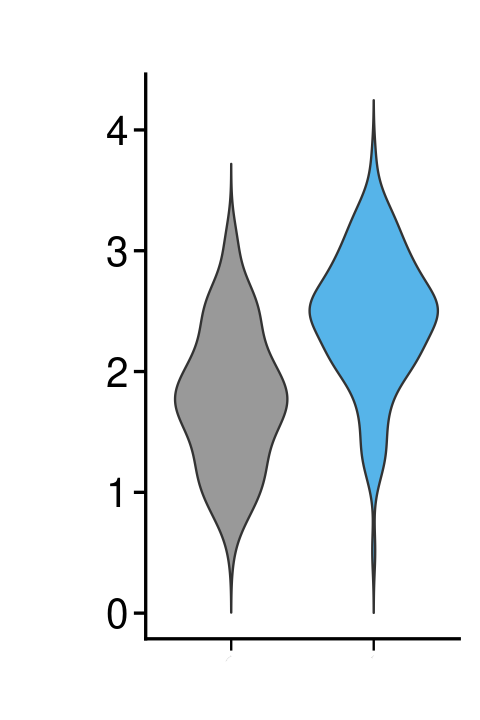

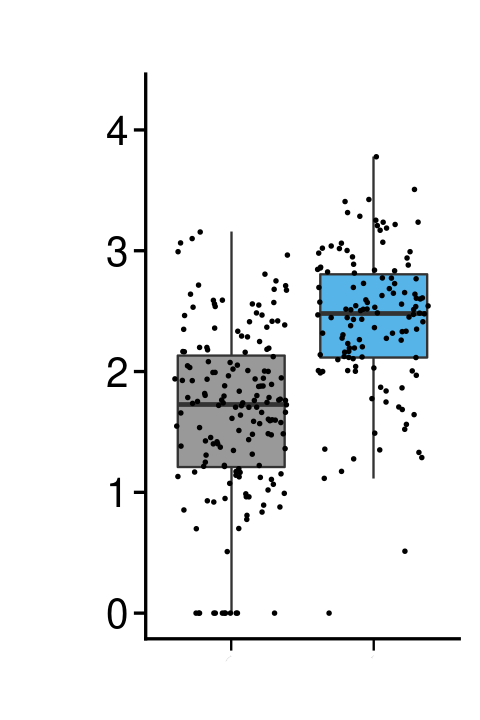

In [35]:
##Making violin for second ANXA1 enhancer hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("chr9.871_490_Gasperini_enhancer")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "ANXA1", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'ANXA1', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001,4.25), breaks = c(0,1,2,3,4)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))



p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter(size = 0.5) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0,4.25), breaks = c(0,1,2,3,4)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))



[1] "finished testing"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
TSPAN5 3.761296e-70   1.098522 0.583 0.047 7.839292e-66


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
TSPAN5,3.761296e-70,1.098522,0.583,0.047,7.839292e-66,48,33946


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 190 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 190 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 56 rows containing missing values (geom_violin).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 97 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 97 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 97 rows containing missing values (geom_point).”


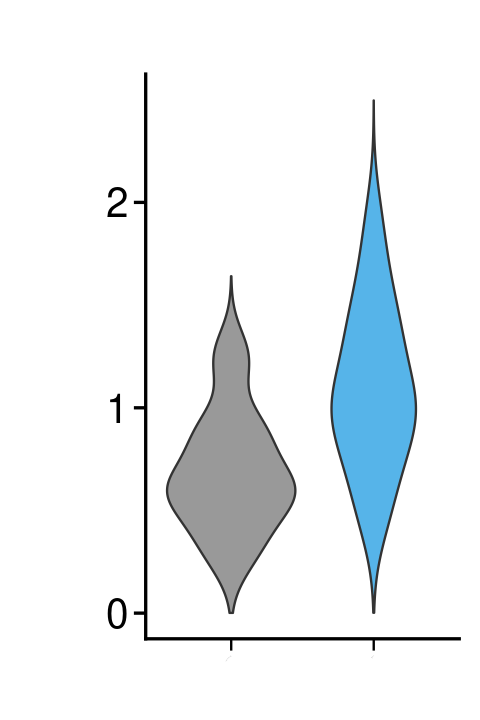

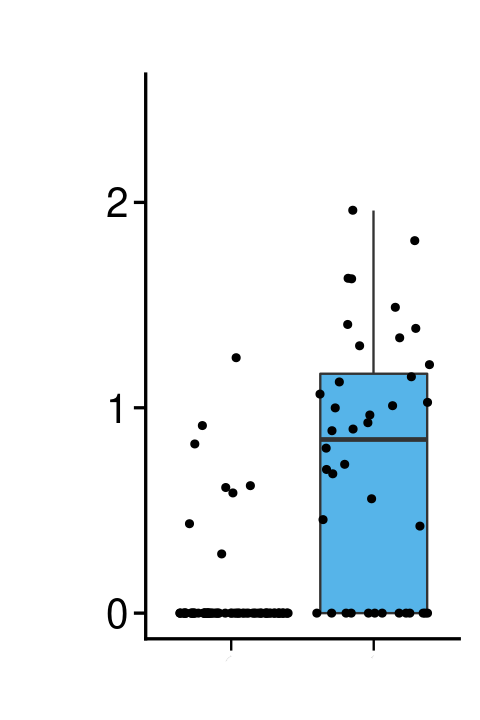

In [36]:
##Making violin for TSPAN5 enhancer hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("chr4.2290_458_Gasperini_enhancer")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "TSPAN5", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'TSPAN5', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001,2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))


p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter() +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0,2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))



[1] "finished testing"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
TMSB4X 2.202116e-26  0.5121239 0.996 0.967 4.589649e-22


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
TMSB4X,2.202116e-26,0.5121239,0.996,0.967,4.589649e-22,260,33734


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 7 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 7 rows containing non-finite values (stat_ydensity).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 4 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


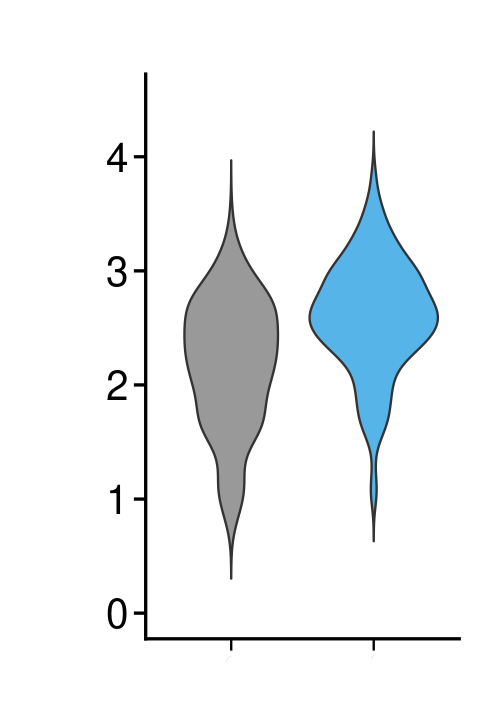

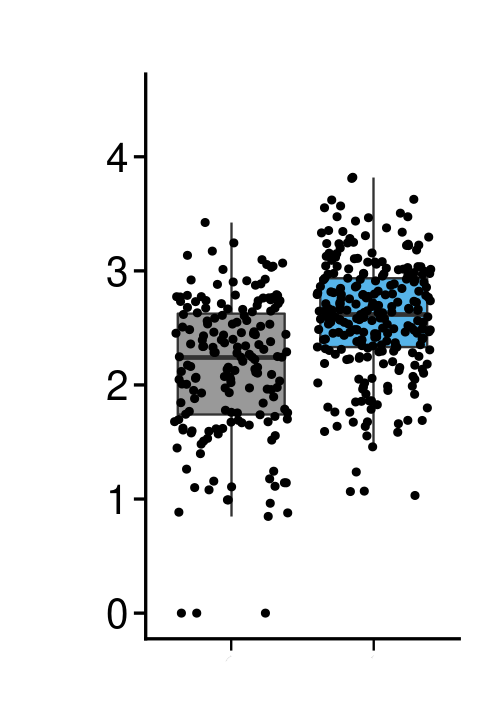

In [37]:
##Making violin for TMSB4X enhancer hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("chrX.232_495_Gasperini_enhancer")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "TMSB4X", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'TMSB4X', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001, 4.5), breaks = c(0,1,2,3,4)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))


p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter() +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0, 4.5), breaks = c(0,1,2,3,4)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))



[1] "finished testing"
             p_val avg_log2FC pct.1 pct.2    p_val_adj
CCND2 9.633994e-27   1.466175 0.767 0.331 2.007917e-22


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
CCND2,9.633994e-27,1.466175,0.767,0.331,2.007917e-22,73,33921


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 143 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 143 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 45 rows containing missing values (geom_violin).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 70 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 70 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 70 rows containing missing values (geom_point).”


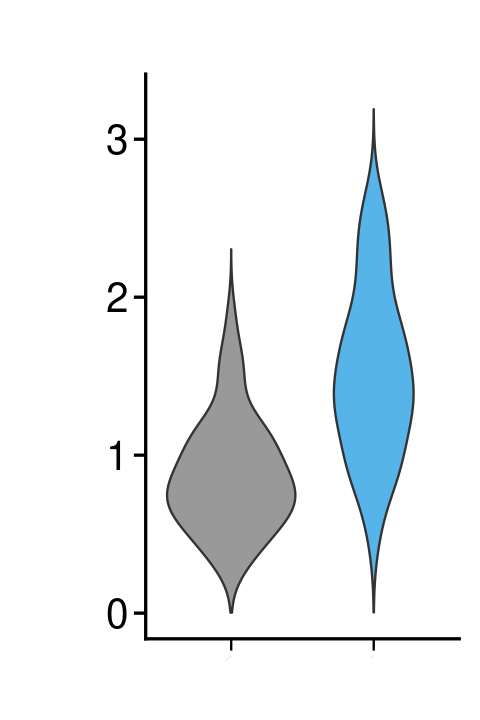

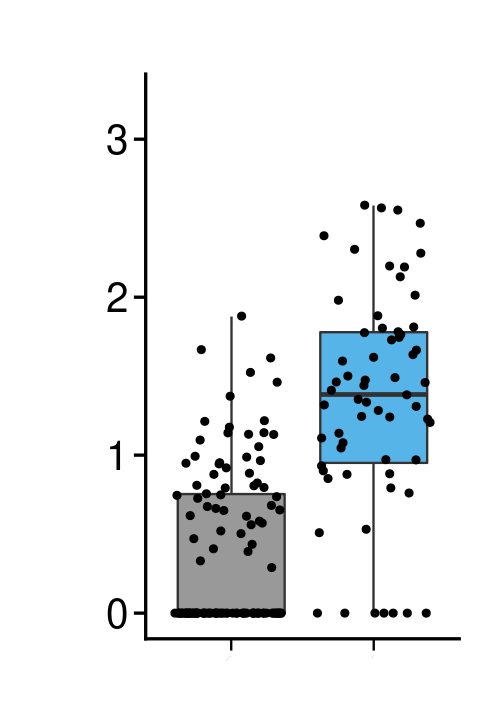

In [40]:
##Making violin for CCND2 TSS hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("CCND2_54_TSS_pos_ctrl")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "CCND2", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'CCND2', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001, 3.25), breaks = c(0,1,2,3)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter() +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0, 3.25), breaks = c(0,1,2,3)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

[1] "finished testing"
     p_val avg_log2FC pct.1 pct.2 p_val_adj
ANK2     0    0.24664 0.124 0.003         0


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ANK2,0,0.24664,0.124,0.003,0,403,33591


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 529 rows containing non-finite values (stat_ydensity).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 529 rows containing non-finite values (stat_ydensity).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 279 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 279 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 279 rows containing missing values (geom_point).”


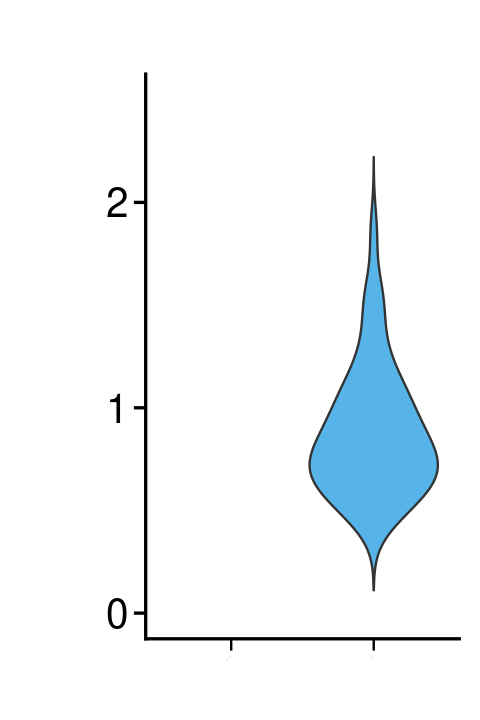

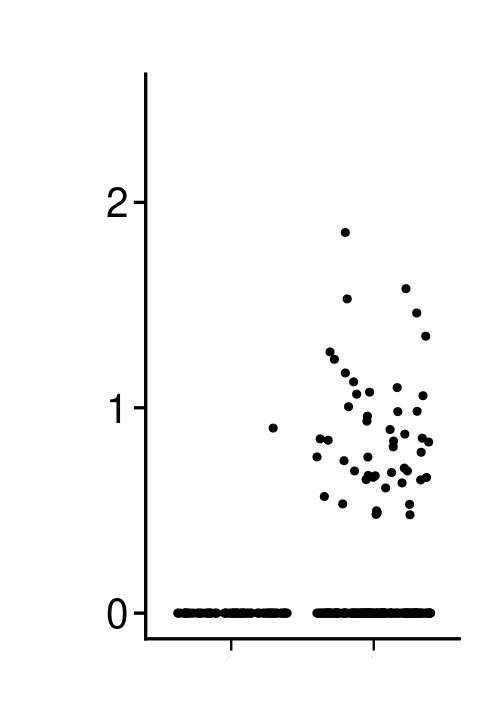

In [43]:
##Making violin for ANK2 promoter hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("ANK2_2_promoter")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "ANK2", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'ANK2', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#56B4E9", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001, 2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

p + scale_fill_manual(values=c("#56B4E9", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter() +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0, 2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

[1] "finished testing"
               p_val avg_log2FC pct.1 pct.2     p_val_adj
BCL11A 1.136112e-251  0.3553158 0.168 0.004 2.367885e-247


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
BCL11A,1.136112e-251,0.3553158,0.168,0.004,2.367885e-247,191,33803


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 334 rows containing non-finite values (stat_ydensity).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 334 rows containing non-finite values (stat_ydensity).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 176 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 176 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 176 rows containing missing values (geom_point).”


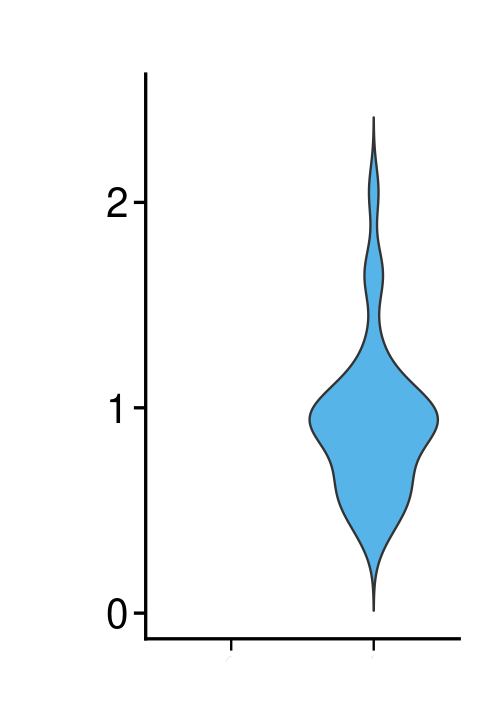

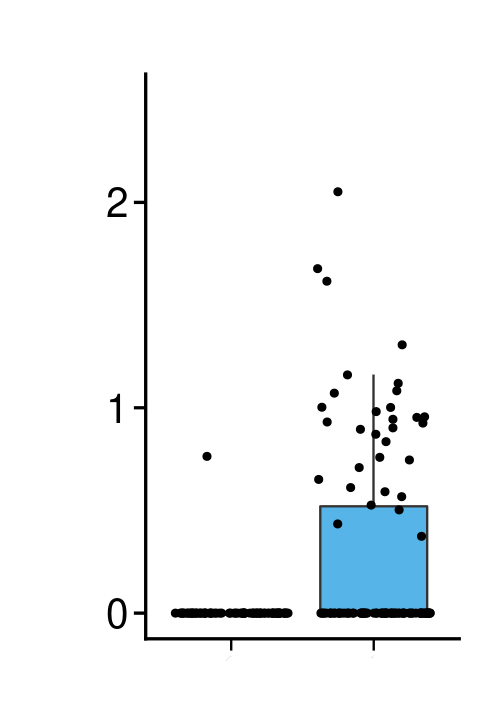

In [44]:
##Making violin for BCL11A promoter hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("BCL11A_41_promoter")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "BCL11A", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'BCL11A', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#56B4E9", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001, 2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

p + scale_fill_manual(values=c("#56B4E9", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter() +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0, 2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

[1] "finished testing"
             p_val avg_log2FC pct.1 pct.2    p_val_adj
FOXP1 3.483233e-21  0.4146709 0.403 0.197 7.259754e-17


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
FOXP1,3.483233e-21,0.4146709,0.403,0.197,7.259754e-17,313,33681


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 333 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 333 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 6 rows containing missing values (geom_violin).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 169 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 169 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 169 rows containing missing values (geom_point).”


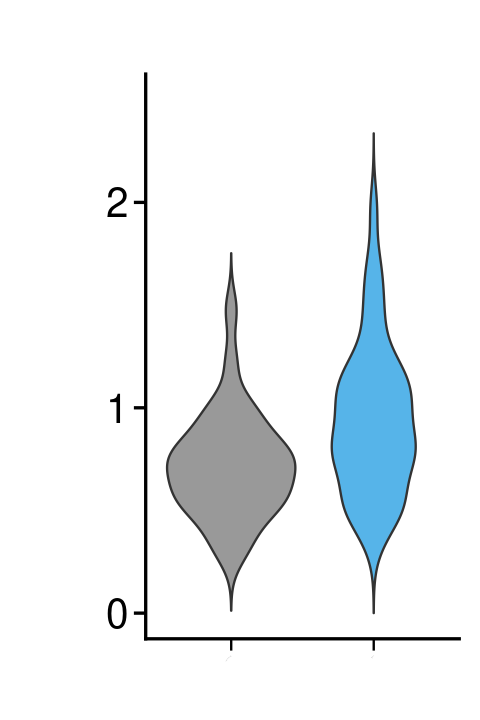

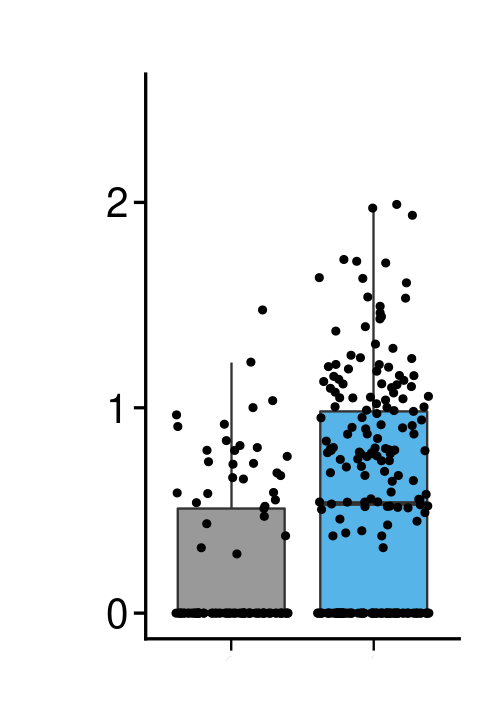

In [46]:
##Making violin for FOXP1 enhancer hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("FOXP1_148_Flashfry_promoter")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "FOXP1", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'FOXP1', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001, 2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter() +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0, 2.5), breaks = c(0,1,2)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))

[1] "finished testing"
            p_val avg_log2FC pct.1 pct.2    p_val_adj
GNB2 9.077682e-26  0.7065594   0.9 0.703 1.891971e-21


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,n_cells,n_control_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
GNB2,9.077682e-26,0.7065594,0.9,0.703,1.891971e-21,220,33774


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 68 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 68 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 11 rows containing missing values (geom_violin).”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 37 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 37 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 37 rows containing missing values (geom_point).”


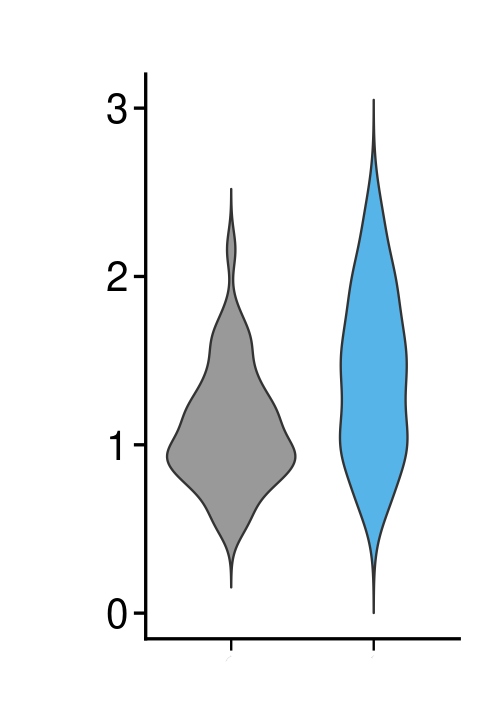

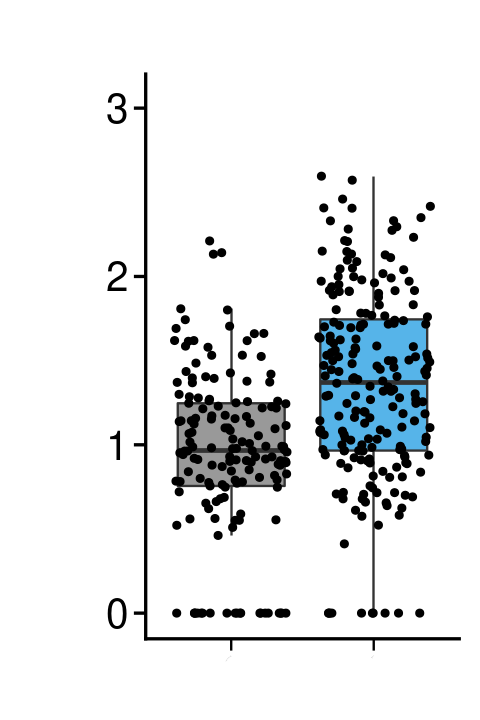

In [47]:
##Making violin for GNB2 TSS positive control hit gRNA

##isolate cells with guide 

gRNA_FBC_DF <- FBC_DF  %>% 
    filter(Gene %in% c("GNB2_180_TSS_pos_ctrl")) %>% 
    filter(UMI_Count > 5) %>% 
    select(Cell)

gRNA_Cells <- gRNA_FBC_DF$Cell 

##Isolate control cells

    # This makes control cells all cells that dont have the targeting guide
        Control_Cells_DF <- FBC_DF %>% 
        filter(!Cell %in% gRNA_Cells)

    Control_Cells <- unique(Control_Cells_DF$Cell)

##Assign those cells to identities in Seurat object for DE testing

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells) <- "Control Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"

##Test for differential expression for a gene of interest

Result <- FindMarkers(CRISPRaQTL_Pilot_Seurat_Object_Subset, ident.1 = "gRNA Cells", 
                 ident.2 = "Control Cells", min.pct = 0, features = "GNB2", logfc.threshold = 0)

print(paste0('finished testing'))
    print(head(Result))
    return(as.data.frame(Result) %>%
           mutate(n_cells=length(gRNA_Cells),
                  n_control_cells=length(Control_Cells)))


##Downsample the control cells to have the same number of cells as those that have the targeting gRNA for plotting

set.seed(26)

##Make a violin plot

Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = gRNA_Cells) <- "gRNA Cells"
Idents(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, cells = Control_Cells_DS) <- "Control Cells Downsample"


options(repr.plot.width=4, repr.plot.height=6)

p = VlnPlot(object = CRISPRaQTL_Pilot_Seurat_Object_Subset, features = 'GNB2', idents = c("Control Cells Downsample", "gRNA Cells"),
       pt.size = 0)
p$layers[[1]]$aes_params$size = 0
p$layers[[1]]$aes_params$fill = NA

p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_violin(size = 0.5, trim = FALSE) +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0.0001, 3.05), breaks = c(0,1,2,3)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))


p + scale_fill_manual(values=c("#999999", "#56B4E9")) +
  geom_boxplot(size = 0.5, outlier.shape = NA) +
  geom_jitter() +
  theme(axis.line = element_line(colour = 'black', size = 0.7)) +
  theme(axis.ticks.y = element_line(colour = "black", size = 0.7)) +
  theme(axis.ticks.length=unit(.25, "cm"), legend.position = "none") +
  labs(title = "", x = "", y = "") +
  scale_y_continuous(labels = scales::number_format(accuracy = 1.0), limits = c(0, 3.05), breaks = c(0,1,2,3)) +
  theme(axis.text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(text = element_text(family="Arial", colour = "black", size = 24)) +
  theme(axis.text.x = element_text(family="Arial", colour = "black", size = 0))+
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 30, b = 0, l = 0)))